**Table of contents**<a id='toc0_'></a>    
- [Dataset](#toc1_)    
    - [Imports](#toc1_1_1_)    
    - [Visualizing the data](#toc1_1_2_)    
    - [Get data](#toc1_1_3_)    
- [Model](#toc2_)    
  - [Number of epochs](#toc2_1_)    
  - [Structure](#toc2_2_)    
  - [Data Augumentation](#toc2_3_)    
  - [Training](#toc2_4_)    
  - [Save model](#toc2_5_)    
  - [Visualizing the metrics](#toc2_6_)    
- [Conclusion](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Dataset](#toc0_)
For this assignment I chose: https://www.kaggle.com/datasets/imsparsh/flowers-dataset

### <a id='toc1_1_1_'></a>[Imports](#toc0_)

In [30]:
# !LD_LIBRARY_PATH=$HOME/miniconda3/lib:$LD_LIBRARY_PATH
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [31]:
import numpy as np
import tensorflow as tf
import keras
import os, shutil

print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

from keras import models
from keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import regularizers
import seaborn as sns
from sklearn import metrics
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.graph_objects as go


TensorFlow version: 2.14.1
Keras version: 2.14.0


### <a id='toc1_1_2_'></a>[Visualizing the data](#toc0_)

In [32]:

def visualize_confusion_matrix_for_models(X_test, Y_test, *models) -> None:
    """
    Visualizes the confusion matrices for multiple machine learning models.

    Parameters:
        X_test (array-like): Test data features.
        Y_test (array-like): True labels for the test data.
        *models (variable-length argument list): Machine learning models to evaluate.

    Returns:
        None. Displays confusion matrices using seaborn's heatmap.
    """
    num_models = len(models)
    plt.figure(figsize=(5 * num_models, 5))
    for i, model in enumerate(models, 1):
        plt.subplot(1, num_models, i)
        Y_pred = model.predict(X_test)
        Y_pred = (Y_pred > 0.5)
        matrix = metrics.confusion_matrix(Y_test, Y_pred)
        hm = sns.heatmap(matrix,
                         cmap='coolwarm',
                         linecolor='white',
                         linewidths=1,
                         annot=True,
                         fmt='d')
        plt.yticks(rotation=0)
        hm.set_ylim(0, len(matrix))
        plt.title(f'Confusion Matrix - Model {i}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(network, test_generator, samples_count: int) -> None:
    '''
    Plots the confusion matrix for the given network and test generator.
    Parameters:
    network: The network to evaluate.
    test_generator: The test generator to use.
    samples_count: The number of samples to use for the evaluation.
    
    Returns:
    None
    '''
    test_generator.reset()

    confusion_matrix = np.zeros((2, 2))
    used_instances = 0

    for images, labels in test_generator:
        if used_instances >= samples_count:
            break

        used_instances += len(labels)

        predictions = network.predict(images, verbose=False)
        
        predicted_labels = (predictions > 0.5).astype(np.int32).reshape(labels.shape)
        confusion_matrix += tf.math.confusion_matrix(labels, predicted_labels, num_classes=2)

    cm = (confusion_matrix / used_instances).numpy()
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
    disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
    plt.show()

    print(f"Accuracy: {np.trace(cm)}")

def matplotlib_plot_accuracy_comparison(*histories, labels: list[str] = None) -> None:
    """
    Plots the training and validation accuracy comparison for multiple models.

    Args:
    *histories: Variable number of history objects. Each history object should contain
                training and validation accuracy values.
    labels: List of labels for each model.
    """
    plt.rcParams['figure.figsize'] = (25.0, 5.0)  # set default size of plots

    for i, history in enumerate(histories):
        epochs = np.arange(1, len(history.history['acc']) + 1)
        
        color = ['b', 'r', 'g', 'c', 'm', 'y'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        
        plt.plot(epochs, acc, color + 'o', label=f'Training accuracy for {label}')
        plt.plot(epochs, val_acc, color, label=f'Validation accuracy for {label}')

    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plotly_plot_accuracy_comparison(*histories, labels: list[str] = None) -> None:
    """
    Plots the training and validation accuracy comparison for multiple models.

    Args:
    *histories: Variable number of history objects. Each history object should contain
                training and validation accuracy values.
    labels: List of labels for each model.
    """
    fig = go.Figure()

    for i, history in enumerate(histories):
        epochs = list(range(1, len(history.history['acc']) + 1))
        
        color = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        
        fig.add_trace(go.Scatter(x=epochs, y=acc, mode='markers', marker=dict(color=color), name=f'Training accuracy for {label}'))
        fig.add_trace(go.Scatter(x=epochs, y=val_acc, mode='lines', line=dict(color=color), name=f'Validation accuracy for {label}'))

    fig.update_layout(title='Comparison of Training and Validation Accuracies',
                      xaxis_title='Epochs',
                      yaxis_title='Accuracy',
                      hovermode='closest')
    fig.show()

def matplotlib_plot_loss_comparison(*histories, labels: list[str] = None) -> None:
    """
    Plots the training and validation loss comparison for multiple models.

    Args:
    *histories: Variable number of history objects. Each history object should contain
                training and validation loss values.
    labels: List of labels for each model.
    """
    plt.rcParams['figure.figsize'] = (25.0, 5.0)  # set default size of plots
    epochs = np.arange(1, len(histories[0].history['loss']) + 1)  # Assuming all models have the same number of epochs

    for i, history in enumerate(histories):
        color = ['b', 'r', 'g', 'c', 'm', 'y'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        plt.plot(epochs, loss, color + 'o', label=f'Training loss for {label}')
        plt.plot(epochs, val_loss, color, label=f'Validation loss for {label}')

    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def print_val_accuracies(*histories) -> None:
    for i, history in enumerate(histories):
        val_accuracy = history.history['val_acc']
        argmax = np.argmax(val_accuracy)
        print(f'Max accuracy for model {i+1} is: {val_accuracy[argmax]}, achieved in the {argmax} epoch.')
  

### <a id='toc1_1_3_'></a>[Get data](#toc0_)

In [33]:
kaggle_dir = "flowers"
    
processed_dir = kaggle_dir + "/processed"
flowers_dir = processed_dir + ""
base_dir = flowers_dir + "/"

train_dir: str = base_dir + "train/"
train_daisy_dir: str = train_dir + "daisy/"
train_dandelion_dir: str = train_dir + "dandelion/"
train_rose_dir: str = train_dir + "rose/"
train_sunflower_dir: str = train_dir + "sunflower/"
train_tulip_dir: str = train_dir + "tulip/"

validation_dir: str = base_dir + "validation/"
validation_daisy_dir: str = validation_dir + "daisy/"
validation_dandelion_dir: str = validation_dir + "dandelion/"
validation_rose_dir: str = validation_dir + "rose/"
validation_sunflower_dir: str = validation_dir + "sunflower/"
validation_tulip_dir: str = validation_dir + "tulip/"

test_dir: str = base_dir + "test/"
test_daisy_dir: str = test_dir + "daisy/"
test_dandelion_dir: str = test_dir + "dandelion/"
test_rose_dir: str = test_dir + "rose/"
test_sunflower_dir: str = test_dir + "sunflower/"
test_tulip_dir: str = test_dir + "tulip/"

models_dir: str = "models/"

In [34]:
def create_dirs() -> None:
    all_paths: list[str] = [kaggle_dir, processed_dir, flowers_dir,
                            base_dir, train_dir, train_daisy_dir, train_dandelion_dir, train_rose_dir, train_sunflower_dir, train_tulip_dir, validation_dir, validation_daisy_dir, validation_dandelion_dir, validation_rose_dir, validation_sunflower_dir, validation_tulip_dir, test_dir, test_daisy_dir, test_dandelion_dir, test_rose_dir, test_sunflower_dir, test_tulip_dir, models_dir]
    # create dirs if not exist
    for path in all_paths:
        if not os.path.exists(path):
            os.makedirs(path)

def copy_train_images(indices: np.ndarray, animal: str ='cat', dir_type: str ='train') -> None:
    for index in indices:
        src: str = f"{kaggle_dir}/original/train/{animal}.{index}.jpg"
        dst: str = f"{kaggle_dir}/processed/flowers/{dir_type}/{animal}s/{animal}.{index}.jpg"
        shutil.copyfile(src, dst)

def remove_images():
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir, ignore_errors=True)

def copy_all_images(validation_size=500, test_size=1000, max_train_size=20000) -> None:
    remove_images()

    create_dirs()
    print("Dirs created")
    
    files: list[str] = os.listdir("kaggle/original/train")

    cats_count: int = sum(1 for file in files if file.startswith("cat"))
    dogs_count: int = sum(1 for file in files if file.startswith("dog"))

    train_size_cats: int = min(cats_count - validation_size - test_size, max_train_size)
    train_size_dogs: int = min(dogs_count - validation_size - test_size, max_train_size)

    indices_cats = np.random.permutation(cats_count)
    indices_dogs = np.random.permutation(dogs_count)

    indices_cats_train = indices_cats[:train_size_cats]
    indices_dogs_train = indices_dogs[:train_size_dogs]

    indices_cats_validation = indices_cats[train_size_cats:train_size_cats + validation_size]
    indices_dogs_validation = indices_dogs[train_size_dogs:train_size_dogs + validation_size]

    indices_cats_test = indices_cats[train_size_cats + validation_size:train_size_cats + validation_size + test_size]
    indices_dogs_test = indices_dogs[train_size_dogs + validation_size:train_size_dogs + validation_size + test_size]


    copy_train_images(indices_cats_train, 'cat', 'train')
    copy_train_images(indices_dogs_train, 'dog', 'train')
    print("Train images copied")

    copy_train_images(indices_cats_validation, 'cat', 'validation')
    copy_train_images(indices_dogs_validation, 'dog', 'validation')
    print("Validation images copied")

    copy_train_images(indices_cats_test, 'cat', 'test')
    copy_train_images(indices_dogs_test, 'dog', 'test')
    print("Test images copied")

    print("All images copied")

# <a id='toc2_'></a>[Model](#toc0_)

## <a id='toc2_1_'></a>[Number of epochs](#toc0_)

In [35]:
epochs_count: int = 160

## <a id='toc2_2_'></a>[Structure](#toc0_)

In [36]:
img_rows, img_cols = 150, 150

model1_a = models.Sequential(
    [
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.Dense(5, activation='softmax')
    ]
)

model1_a.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

model1_a.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 conv2d_44 (Conv2D)          (None, 146, 146, 32)      4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 73, 73, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 35, 35, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 33, 33, 64)      

In [37]:
model2_a = models.Sequential(
    [
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(5, activation='softmax')
    ]
)

model2_a.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model2_a.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 batch_normalization_22 (Ba  (None, 72, 72, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_49 (Conv2D)          (None, 70, 70, 64)        18496     
                                                                 
 batch_normalization_23 (Ba  (None, 70, 70, 64)      

In [38]:
model3_a = models.Sequential(
    [
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.MaxPooling2D((3, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dense(5, activation='softmax')
    ]
)

model3_a.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model3_a.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 49, 49, 16)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_25 (Ba  (None, 49, 49, 16)        64        
 tchNormalization)                                               
                                                                 
 conv2d_52 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                     

                                                                 
 dense_25 (Dense)            (None, 5)                 645       
                                                                 
Total params: 843749 (3.22 MB)
Trainable params: 843653 (3.22 MB)
Non-trainable params: 96 (384.00 Byte)
_________________________________________________________________


In [39]:
model4_a = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dense(5, activation='softmax')
    ]
)

model4_a.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model4_a.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_55 (Conv2D)          (None, 146, 146, 64)      18496     
                                                                 
 batch_normalization_27 (Ba  (None, 146, 146, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_56 (Conv2D)          (None, 144, 144, 64)      36928     
                                                                 
 batch_normalization_28 (Ba  (None, 144, 144, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 48, 48, 64)      

In [40]:
model5_a = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dense(5, activation='softmax')
    ]
)

model5_a.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=['acc'])

model5_a.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 conv2d_60 (Conv2D)          (None, 146, 146, 64)      18496     
                                                                 
 batch_normalization_31 (Ba  (None, 146, 146, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_61 (Conv2D)          (None, 144, 144, 64)      36928     
                                                                 
 batch_normalization_32 (Ba  (None, 144, 144, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 48, 48, 64)      

## <a id='toc2_3_'></a>[Data Augumentation](#toc0_)

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_rows, img_cols),
        class_mode='categorical',
        batch_size=10) #32
        # Since we use binary_crossentropy loss, we need binary labels)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        class_mode='categorical',
        target_size=(img_rows, img_cols),
        batch_size=4)#32)

Found 2496 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


## <a id='toc2_4_'></a>[Training](#toc0_)

In [42]:
# history1 = model1.fit_generator(
history1_a = model1_a.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=epochs_count,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/160
100/100 [==============================] - 9s 68ms/step - loss: 1.5707 - acc: 0.2780 - val_loss: 1.4555 - val_acc: 0.3350
Epoch 2/160
100/100 [==============================] - 7s 68ms/step - loss: 1.3353 - acc: 0.4150 - val_loss: 1.2371 - val_acc: 0.4900
Epoch 3/160
100/100 [==============================] - 7s 68ms/step - loss: 1.2225 - acc: 0.4560 - val_loss: 1.1885 - val_acc: 0.4950
Epoch 4/160
100/100 [==============================] - 7s 70ms/step - loss: 1.2012 - acc: 0.4829 - val_loss: 1.3912 - val_acc: 0.4250
Epoch 5/160
100/100 [==============================] - 6s 60ms/step - loss: 1.1222 - acc: 0.5520 - val_loss: 1.1709 - val_acc: 0.5100
Epoch 6/160
100/100 [==============================] - 8s 80ms/step - loss: 1.0844 - acc: 0.5600 - val_loss: 1.1323 - val_acc: 0.5200
Epoch 7/160
100/100 [==============================] - 8s 76ms/step - loss: 1.0750 - acc: 0.5612 - val_loss: 1.1321 - val_acc: 0.5050
Epoch 8/160
100/100 [==============================] - 6s 63ms

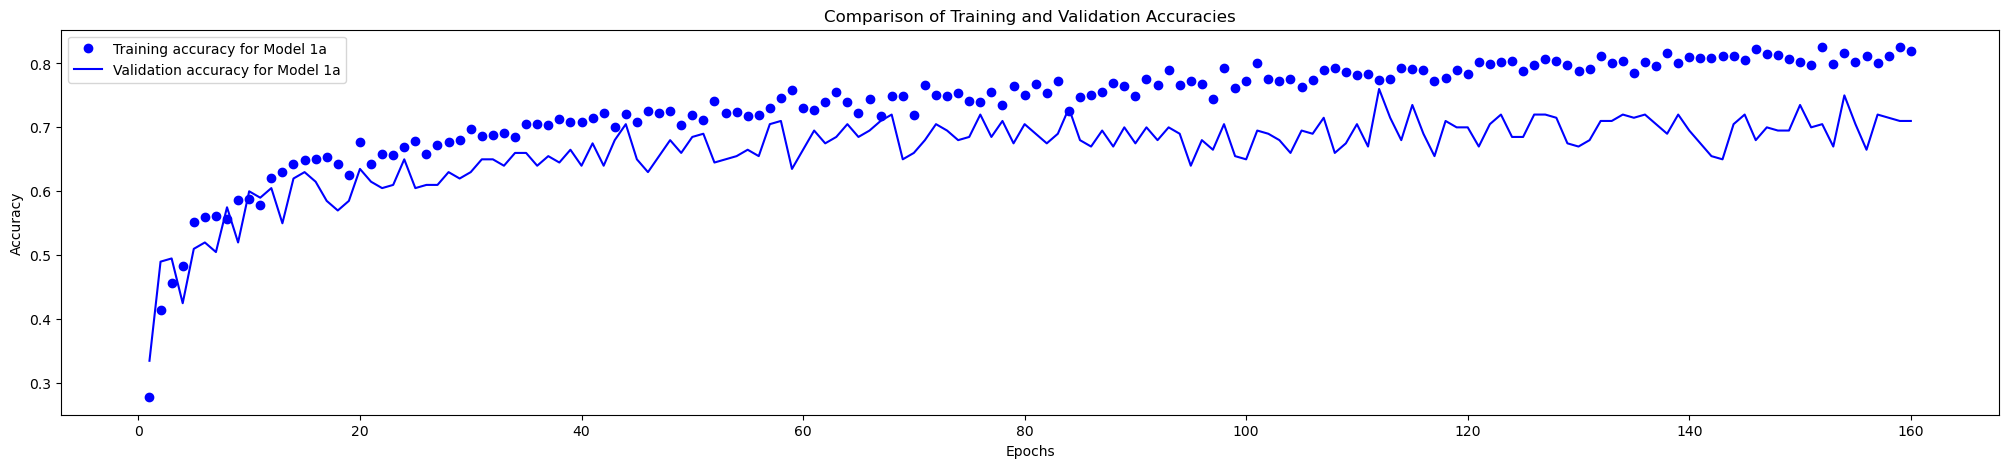

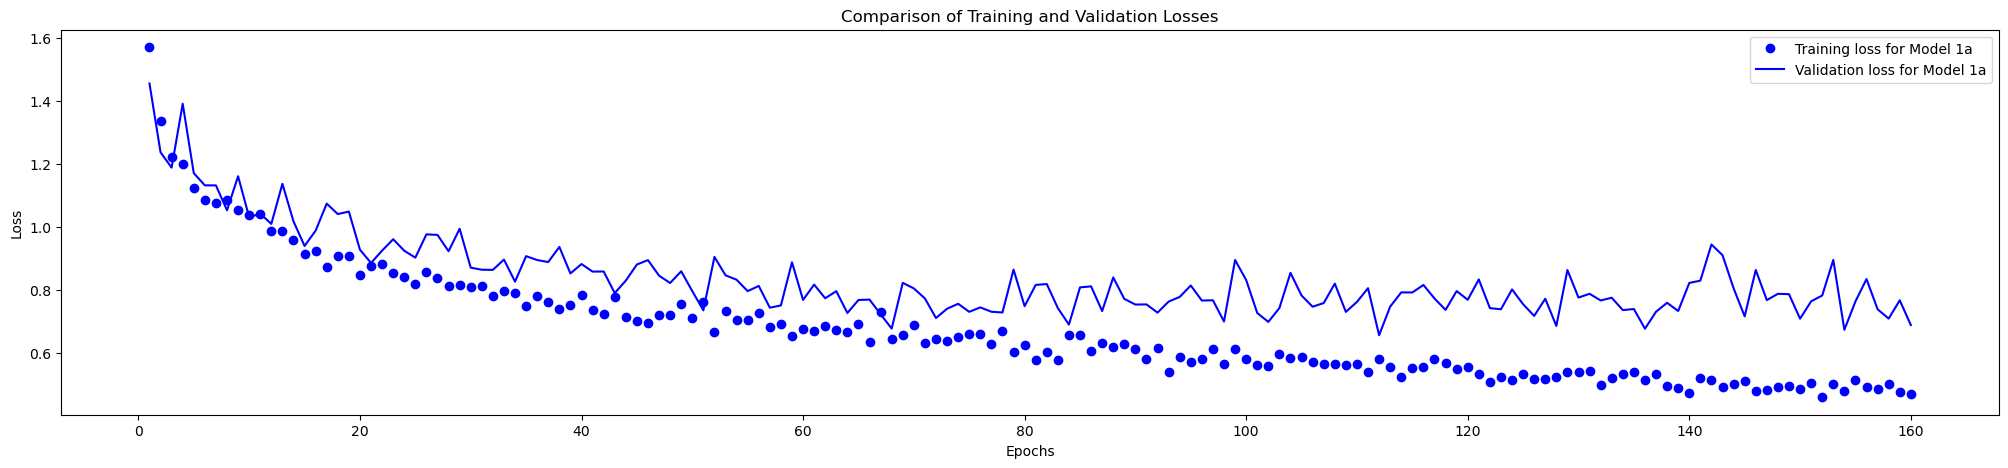

In [43]:
matplotlib_plot_accuracy_comparison(history1_a, labels=['Model 1a'])
matplotlib_plot_loss_comparison(history1_a, labels=['Model 1a'])

In [44]:
history2_a = model2_a.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50)

Epoch 1/160
 48/100 [=============>................] - ETA: 2s - loss: 3.9407 - acc: 0.3298

100/100 [==============================] - 8s 58ms/step - loss: 3.7370 - acc: 0.3524 - val_loss: 2.2676 - val_acc: 0.2000
Epoch 2/160
100/100 [==============================] - 5s 55ms/step - loss: 2.7984 - acc: 0.4307 - val_loss: 2.8553 - val_acc: 0.2250
Epoch 3/160
100/100 [==============================] - 6s 63ms/step - loss: 2.1835 - acc: 0.4418 - val_loss: 3.0902 - val_acc: 0.2500
Epoch 4/160
100/100 [==============================] - 9s 89ms/step - loss: 2.0711 - acc: 0.4580 - val_loss: 2.6966 - val_acc: 0.3550
Epoch 5/160
100/100 [==============================] - 5s 53ms/step - loss: 1.8068 - acc: 0.5070 - val_loss: 2.3556 - val_acc: 0.4450
Epoch 6/160
100/100 [==============================] - 5s 52ms/step - loss: 1.7335 - acc: 0.5190 - val_loss: 2.4467 - val_acc: 0.4700
Epoch 7/160
100/100 [==============================] - 5s 53ms/step - loss: 1.8458 - acc: 0.5251 - val_loss: 2.0333 - val_acc: 0.4950
Epoch 8/160
100/100 [==============================] - 5s 53ms/step - loss

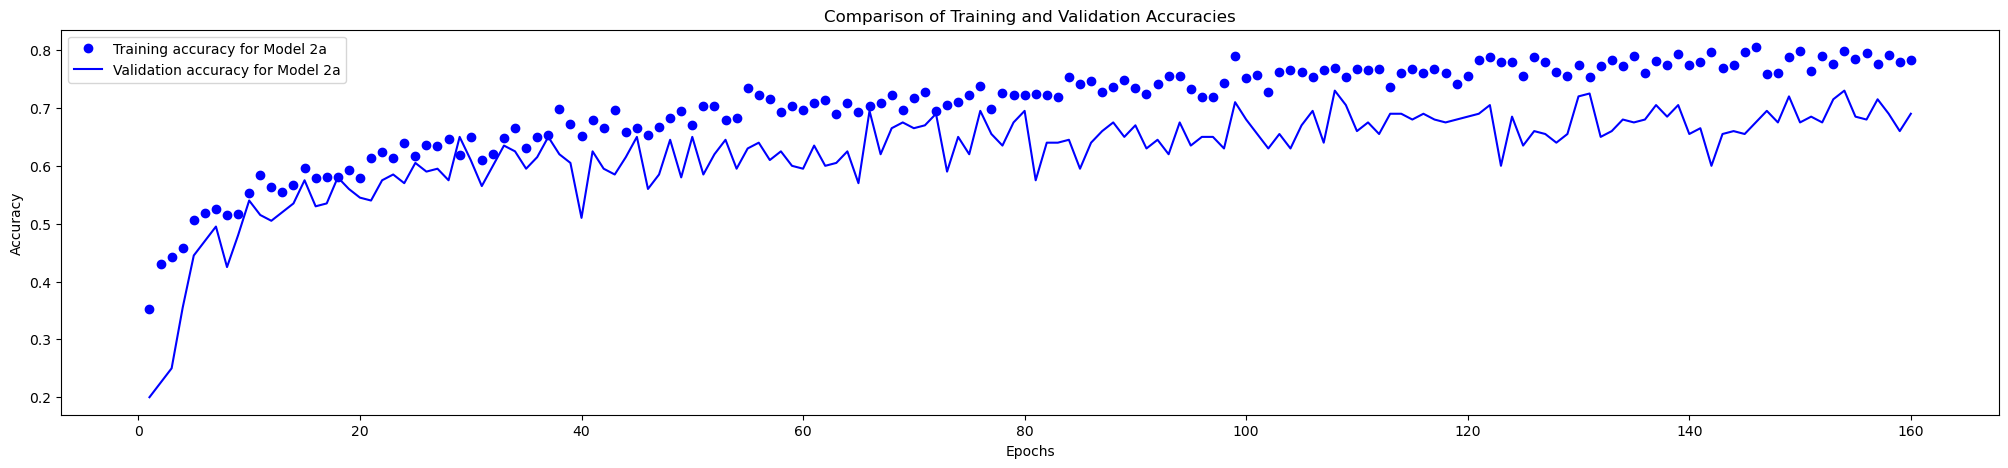

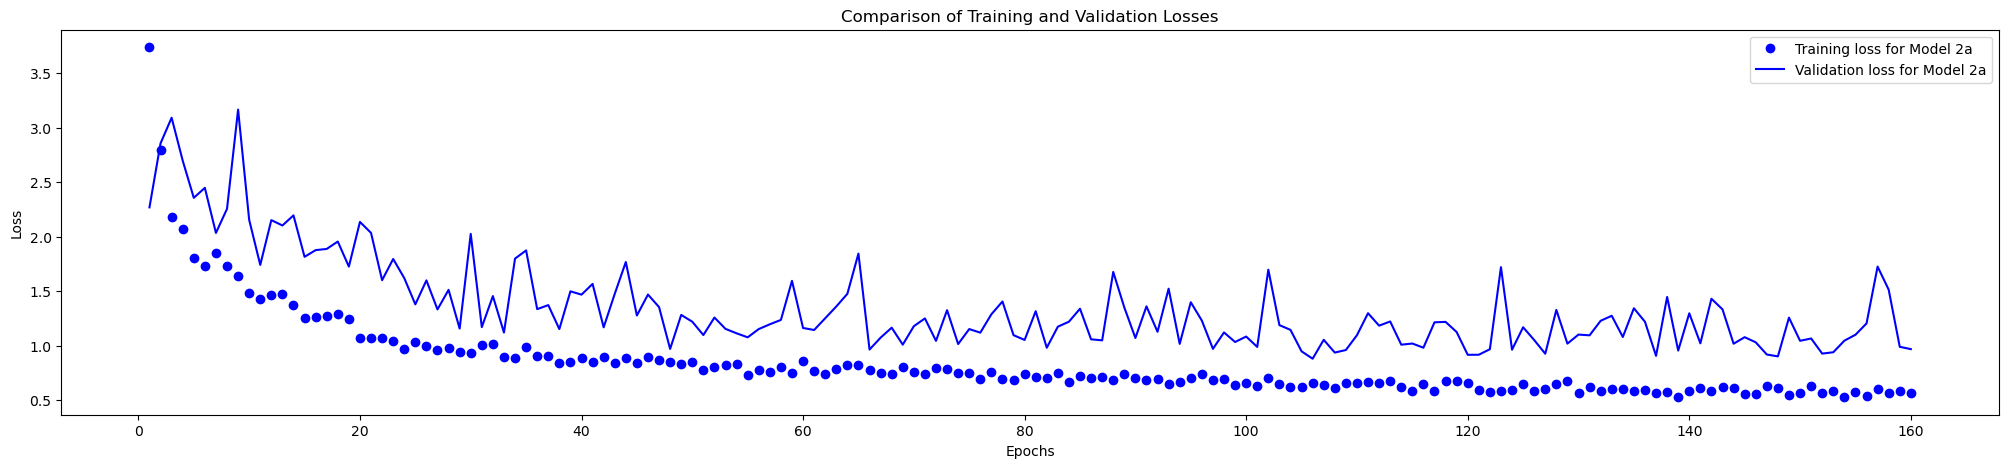

In [45]:
matplotlib_plot_accuracy_comparison(history2_a, labels=['Model 2a'])
matplotlib_plot_loss_comparison(history2_a, labels=['Model 2a'])

In [46]:
history3_a = model3_a.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/160
100/100 [==============================] - 8s 59ms/step - loss: 1.4543 - acc: 0.3876 - val_loss: 1.5954 - val_acc: 0.2000
Epoch 2/160
100/100 [==============================] - 6s 57ms/step - loss: 1.2670 - acc: 0.4800 - val_loss: 1.9042 - val_acc: 0.1950
Epoch 3/160
100/100 [==============================] - 9s 90ms/step - loss: 1.1811 - acc: 0.5040 - val_loss: 1.5701 - val_acc: 0.2750
Epoch 4/160
100/100 [==============================] - 6s 59ms/step - loss: 1.1715 - acc: 0.5301 - val_loss: 1.3853 - val_acc: 0.3900
Epoch 5/160
100/100 [==============================] - 6s 56ms/step - loss: 1.1396 - acc: 0.5230 - val_loss: 1.1753 - val_acc: 0.5000
Epoch 6/160
100/100 [==============================] - 6s 56ms/step - loss: 1.1123 - acc: 0.5520 - val_loss: 1.1641 - val_acc: 0.5050
Epoch 7/160
100/100 [==============================] - 6s 57ms/step - loss: 1.0444 - acc: 0.5670 - val_loss: 1.1024 - val_acc: 0.5700
Epoch 8/160
100/100 [==============================] - 9s 87ms

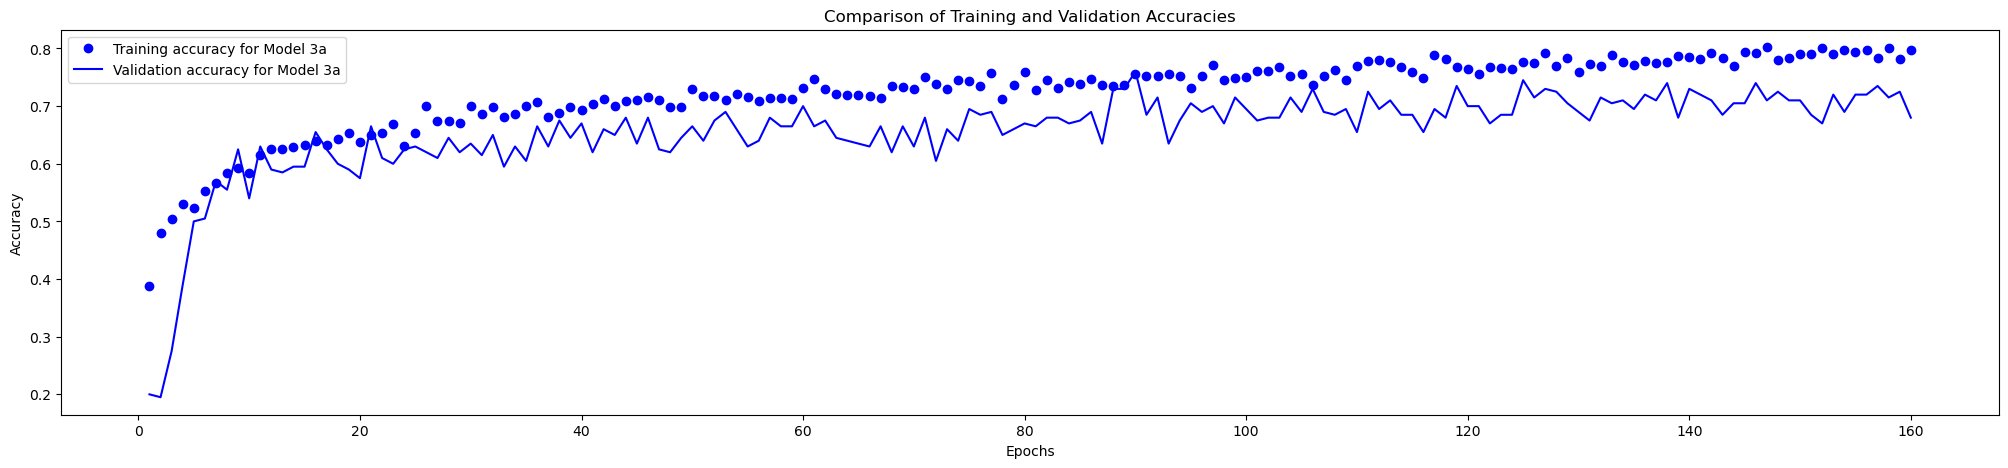

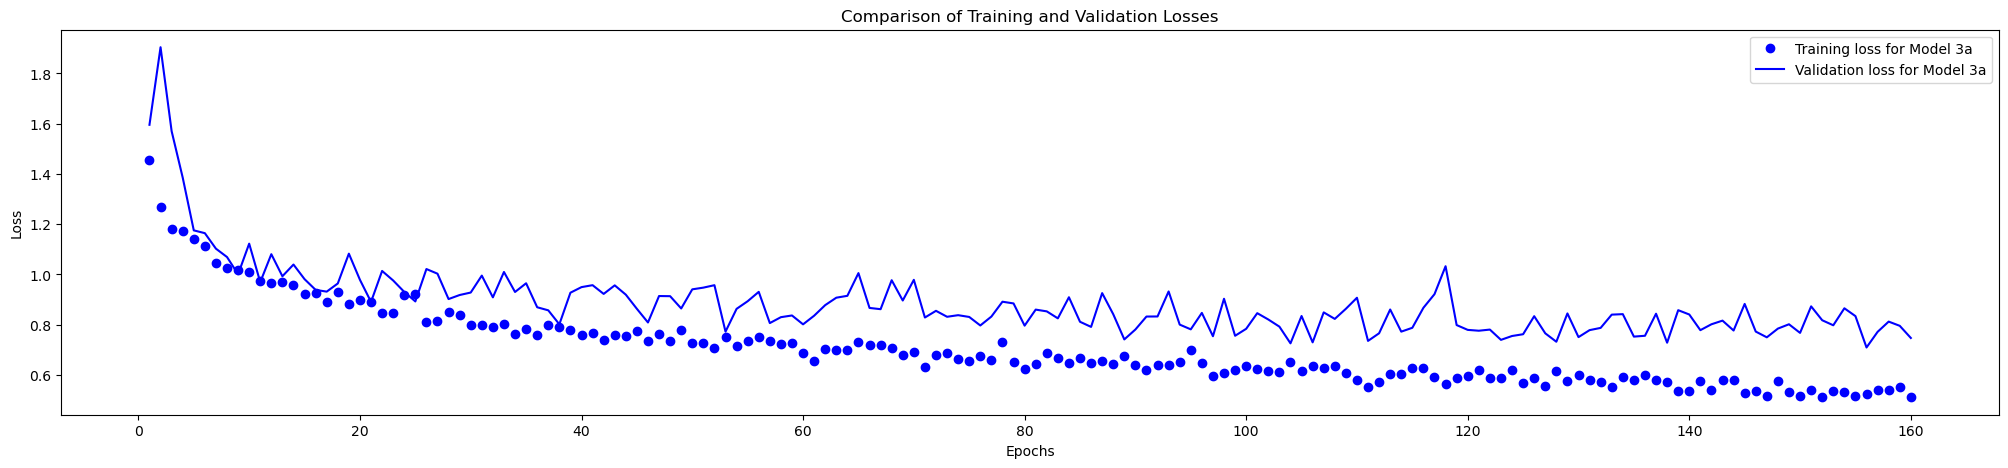

In [47]:
matplotlib_plot_accuracy_comparison(history3_a, labels=['Model 3a'])
matplotlib_plot_loss_comparison(history3_a, labels=['Model 3a'])

In [48]:
history4_a = model4_a.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/160


2024-04-15 21:33:29.994212: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_13/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 11s 88ms/step - loss: 5.2671 - acc: 0.3850 - val_loss: 3.8321 - val_acc: 0.1900
Epoch 2/160
100/100 [==============================] - 7s 73ms/step - loss: 4.0543 - acc: 0.4090 - val_loss: 15.8763 - val_acc: 0.2150
Epoch 3/160
100/100 [==============================] - 10s 102ms/step - loss: 3.6929 - acc: 0.4430 - val_loss: 11.8938 - val_acc: 0.1800
Epoch 4/160
100/100 [==============================] - 7s 74ms/step - loss: 3.2897 - acc: 0.4430 - val_loss: 4.4787 - val_acc: 0.2400
Epoch 5/160
100/100 [==============================] - 8s 78ms/step - loss: 3.2352 - acc: 0.4540 - val_loss: 3.0260 - val_acc: 0.3350
Epoch 6/160
100/100 [==============================] - 8s 77ms/step - loss: 2.9544 - acc: 0.4500 - val_loss: 2.5274 - val_acc: 0.3300
Epoch 7/160
100/100 [==============================] - 12s 123ms/step - loss: 2.3570 - acc: 0.4749 - val_loss: 2.3167 - val_acc: 0.3550
Epoch 8/160
100/100 [==============================] - 10s 97ms/ste

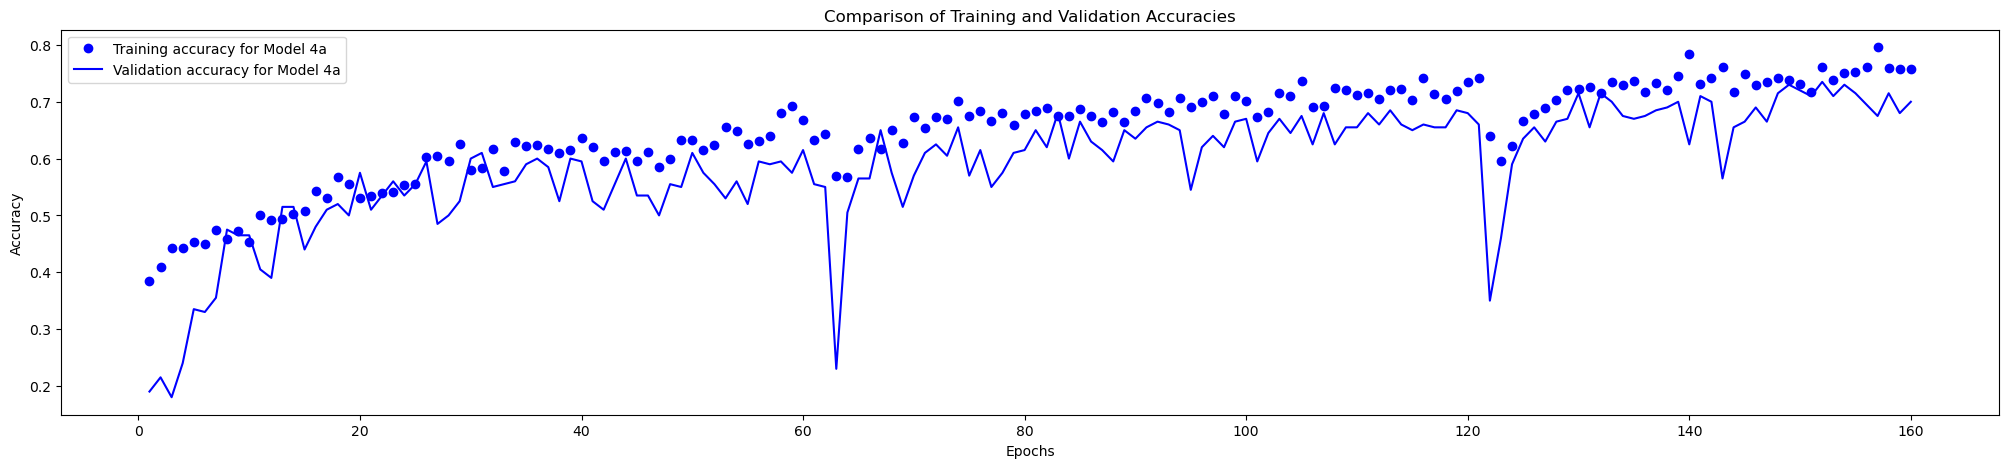

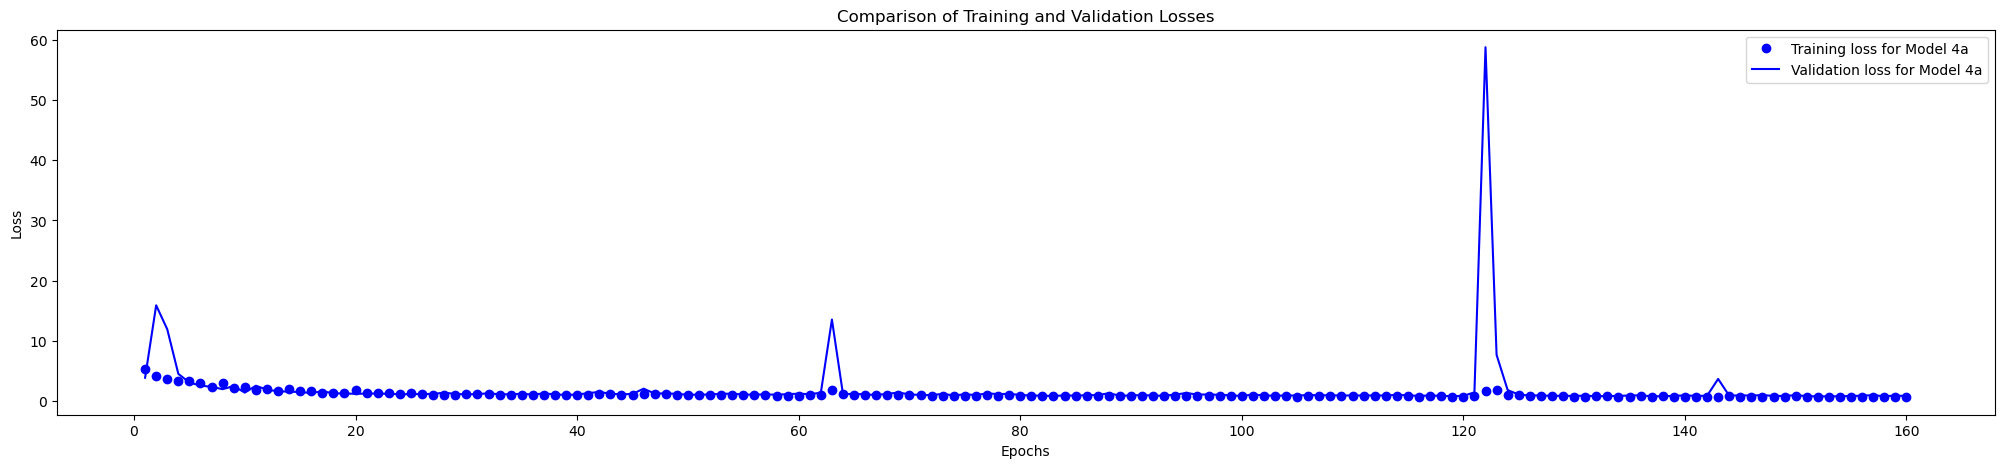

In [49]:
matplotlib_plot_accuracy_comparison(history4_a, labels=['Model 4a'])
matplotlib_plot_loss_comparison(history4_a, labels=['Model 4a'])

In [50]:
history5_a = model5_a.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs_count,
        validation_data=validation_generator,
        validation_steps=50
        )

Epoch 1/160


2024-04-15 22:00:22.724654: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_14/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - 17s 139ms/step - loss: 4.9931 - acc: 0.3600 - val_loss: 2.5925 - val_acc: 0.1950
Epoch 2/160
100/100 [==============================] - 11s 112ms/step - loss: 3.7569 - acc: 0.4016 - val_loss: 3.3991 - val_acc: 0.2500
Epoch 3/160
100/100 [==============================] - 10s 104ms/step - loss: 3.3870 - acc: 0.4006 - val_loss: 2.3432 - val_acc: 0.1750
Epoch 4/160
100/100 [==============================] - 13s 131ms/step - loss: 3.3622 - acc: 0.4006 - val_loss: 2.0548 - val_acc: 0.1850
Epoch 5/160
100/100 [==============================] - 10s 104ms/step - loss: 3.0745 - acc: 0.4150 - val_loss: 2.6113 - val_acc: 0.3550
Epoch 6/160
100/100 [==============================] - 10s 102ms/step - loss: 2.8520 - acc: 0.4370 - val_loss: 1.9519 - val_acc: 0.4350
Epoch 7/160
100/100 [==============================] - 13s 130ms/step - loss: 2.7068 - acc: 0.4480 - val_loss: 2.4686 - val_acc: 0.3300
Epoch 8/160
100/100 [==============================] - 10s 1

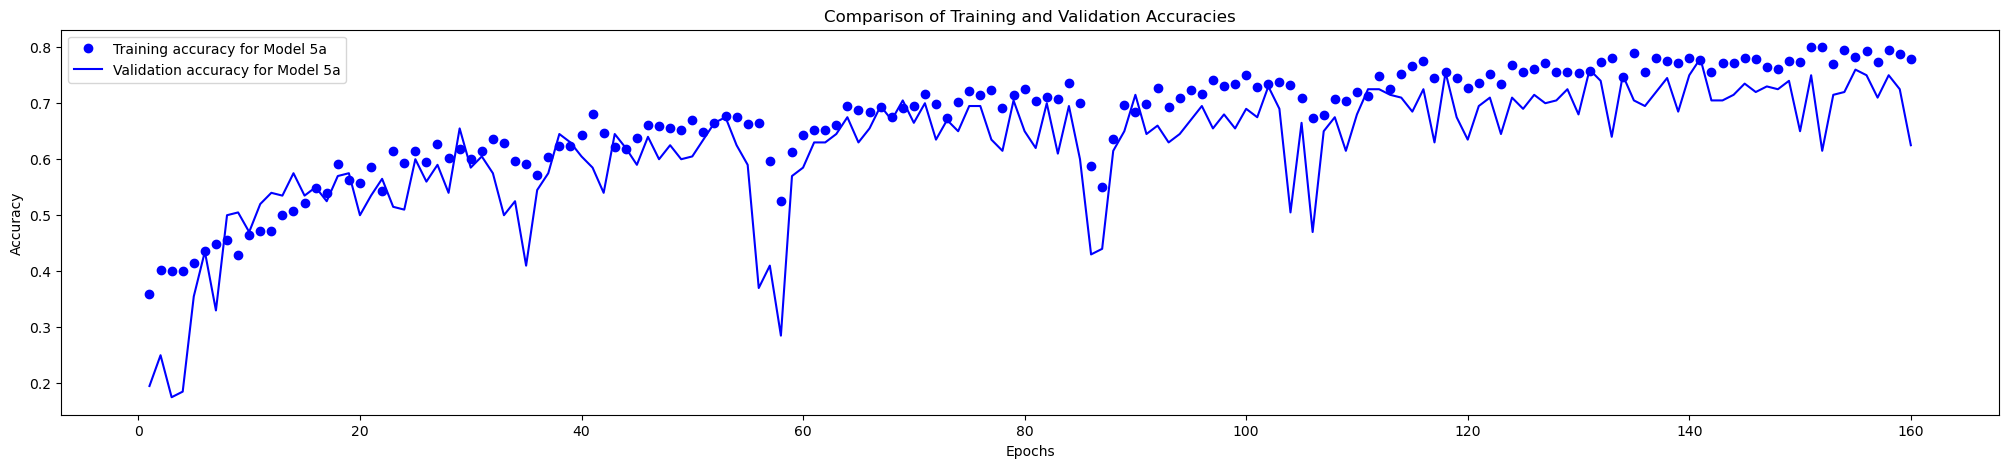

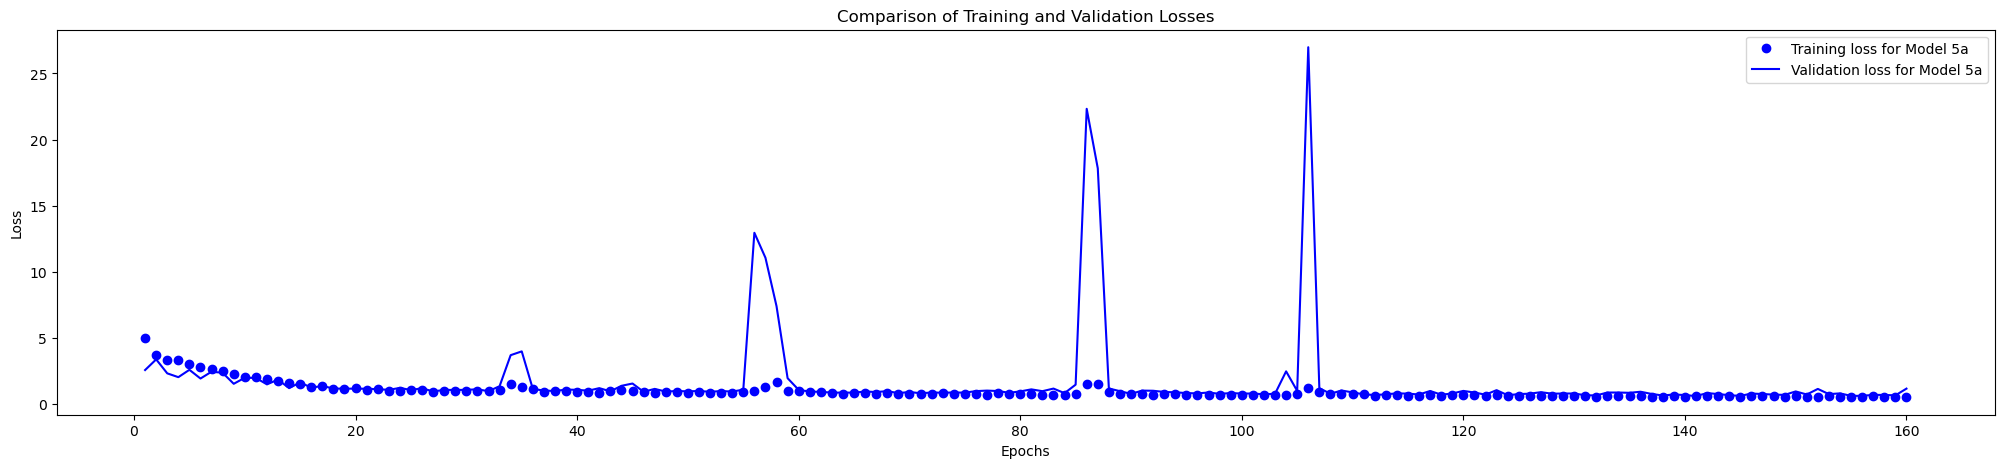

In [51]:
matplotlib_plot_accuracy_comparison(history5_a, labels=['Model 5a'])
matplotlib_plot_loss_comparison(history5_a, labels=['Model 5a'])

## <a id='toc2_5_'></a>[Save model](#toc0_)

In [52]:
model1_a.save(models_dir + 'cats_and_dogs_1.keras')
model2_a.save(models_dir + 'cats_and_dogs_2.keras')
model3_a.save(models_dir + 'cats_and_dogs_3.keras')
model4_a.save(models_dir + 'cats_and_dogs_4.keras')
model5_a.save(models_dir + 'cats_and_dogs_5.keras')


## <a id='toc2_6_'></a>[Visualizing the metrics](#toc0_)

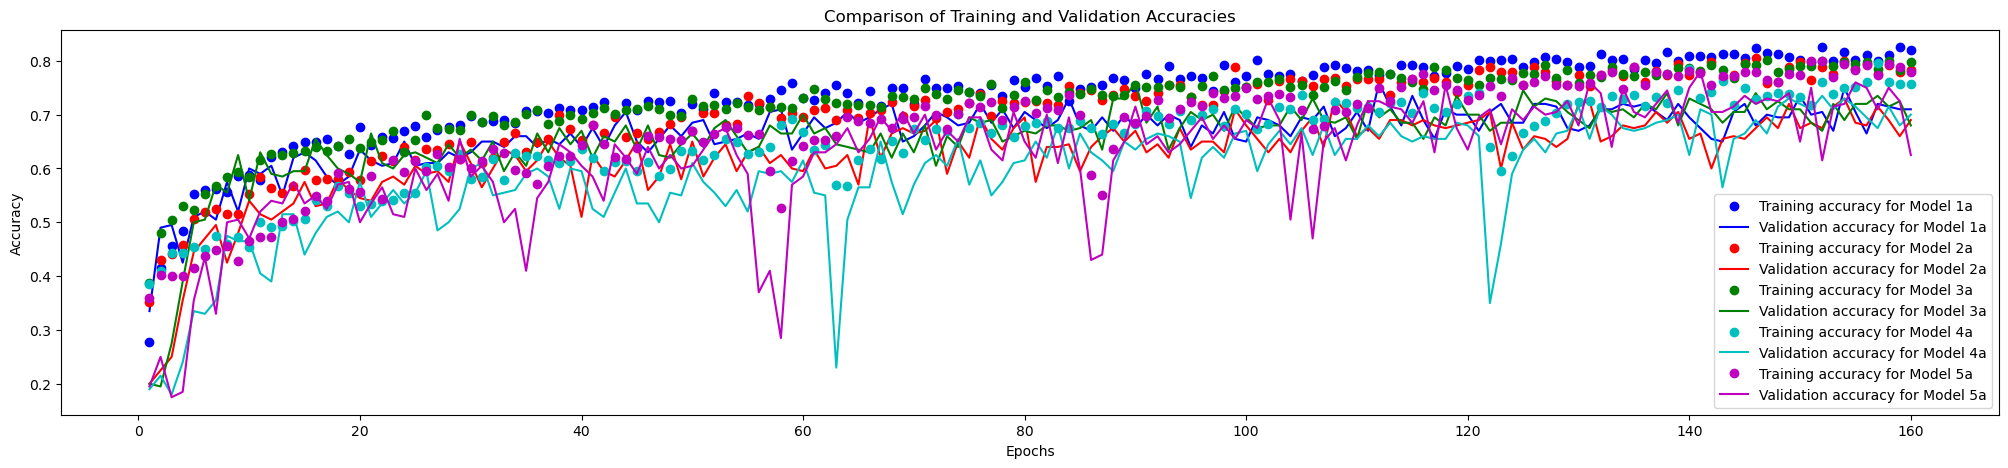

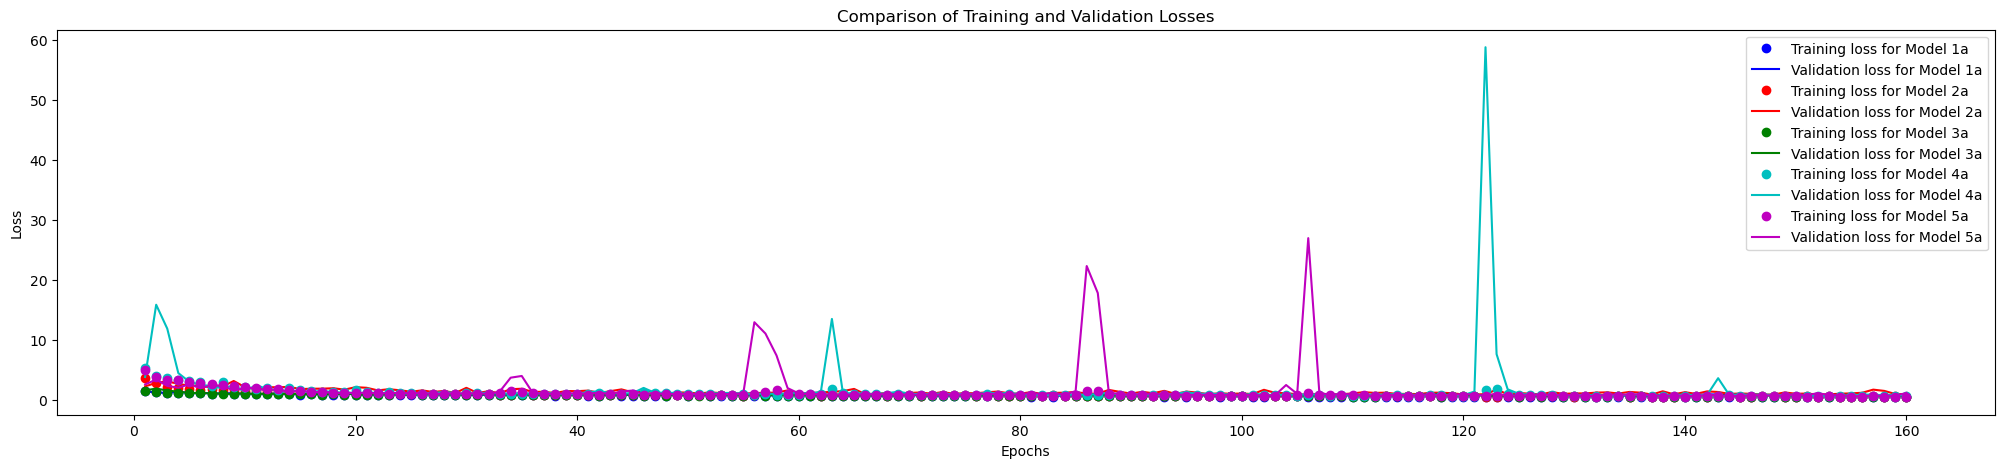

Max accuracy for model 1 is: 0.7599999904632568, achieved in the 111 epoch.
Max accuracy for model 2 is: 0.7300000190734863, achieved in the 107 epoch.
Max accuracy for model 3 is: 0.7599999904632568, achieved in the 89 epoch.
Max accuracy for model 4 is: 0.7350000143051147, achieved in the 151 epoch.
Max accuracy for model 5 is: 0.7799999713897705, achieved in the 140 epoch.


In [53]:
matplotlib_plot_accuracy_comparison(history1_a, history2_a, history3_a, history4_a, history5_a, labels=['Model 1a', 'Model 2a', 'Model 3a', 'Model 4a', 'Model 5a'])
matplotlib_plot_loss_comparison(history1_a, history2_a, history3_a, history4_a, history5_a, labels=['Model 1a', 'Model 2a', 'Model 3a', 'Model 4a', 'Model 5a'])
print_val_accuracies(history1_a, history2_a, history3_a, history4_a, history5_a)

# <a id='toc3_'></a>[Conclusion](#toc0_)

Unfortunately, this competition proved to be exceptionally difficult. All NNs from Cats&Dogs competition did not yield any satisfactory results, they achieved low scores and were prone to overfitting. I tried to combat it with various techniques, but to no avail, probably due to size of the dataset.  
This is why I decided to severely reduce size of all my NNs, this proved to be a step in right direction, but despite my best efforts results were not stellar.